# Basic Dataset 

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, roc_curve, classification_report
from dmba import classificationSummary
import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

plt.style.use('bmh')
%matplotlib inline

In [2]:
# import dataset
open_table = pd.read_csv('email_opened_table.csv')
open_table['open'] = 1
open_table.head(3)

,email_id,open
0,284534,1
1,609056,1
2,220820,1


In [3]:
# email table
email = pd.read_csv('email_table.csv')
email.head(3)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2


In [4]:
# link and click table
link_click = pd.read_csv('link_clicked_table.csv')
link_click['click'] = 1
link_click.head(3)

,email_id,click
0,609056,1
1,870980,1
2,935124,1


In [5]:
# email table combine with email
email_click = pd.merge(email,
                       link_click,
                       how='left',
                       left_on='email_id',
                       right_on='email_id')
email_click

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,click
0,85120,short_email,personalized,2,Sunday,US,5,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1.0
2,777221,long_email,personalized,11,Wednesday,US,2,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN
...,...,...,...,...,...,...,...,...
99995,803504,short_email,personalized,4,Monday,US,5,NaN
99996,899722,long_email,personalized,7,Saturday,US,1,NaN
99997,449610,long_email,personalized,11,Saturday,UK,6,NaN
99998,72497,short_email,generic,10,Monday,UK,0,NaN


In [6]:
# total data
total_df = pd.merge(email_click,
                    open_table,
                    how='left',
                    left_on='email_id',
                    right_on='email_id')

In [7]:
# total data information
total_df.fillna(0, inplace=True)
total_df['open'] = total_df['open'].astype(int)
total_df['click'] = total_df['click'].astype(int)
total_df.head(2)

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,click,open
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1


In [8]:
# inspect data
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
 7   click                100000 non-null  int64 
 8   open                 100000 non-null  int64 
dtypes: int64(5), object(4)
memory usage: 7.6+ MB


# Data Exploration Analysis

## Category Variables Exploration

In [9]:
def plot_cat(col):

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x=col, data=total_df, ax=ax[0])
    ax[0].set_xlabel(col, fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Count Plot of ' + col, fontsize=16)

    sns.barplot(x=col, y='click', data=total_df, ax=ax[1])
    ax[1].set_xlabel(col, fontsize=12)
    ax[1].set_ylabel('Click Through Rate', fontsize=12)
    ax[1].set_title('Click Through Rate vs. ' + col, fontsize=16)
    plt.tight_layout()
    plt.show()

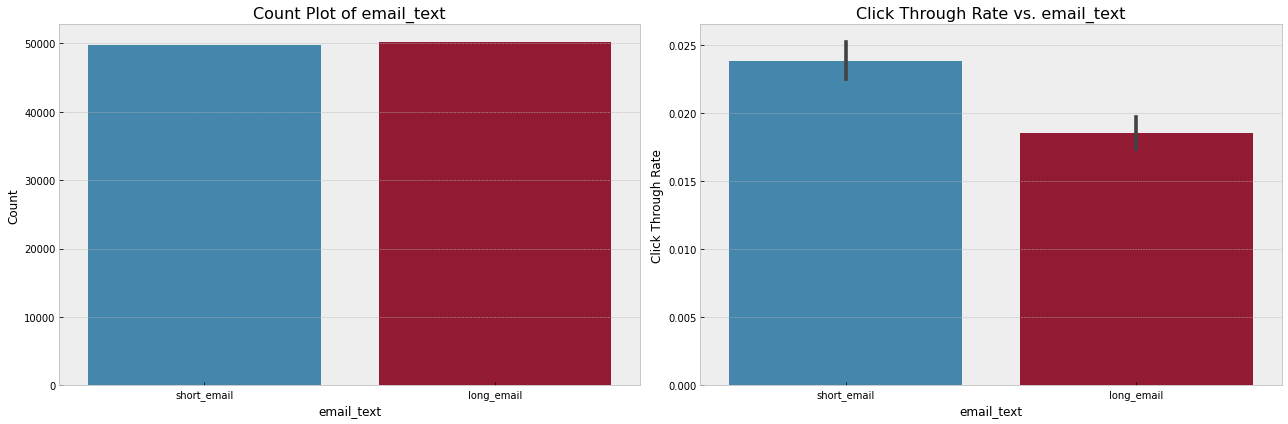

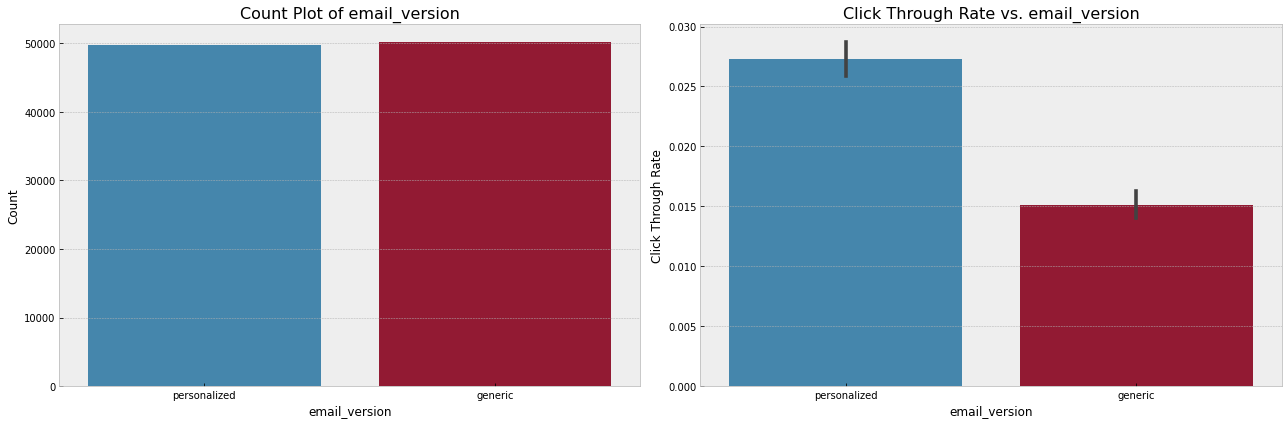

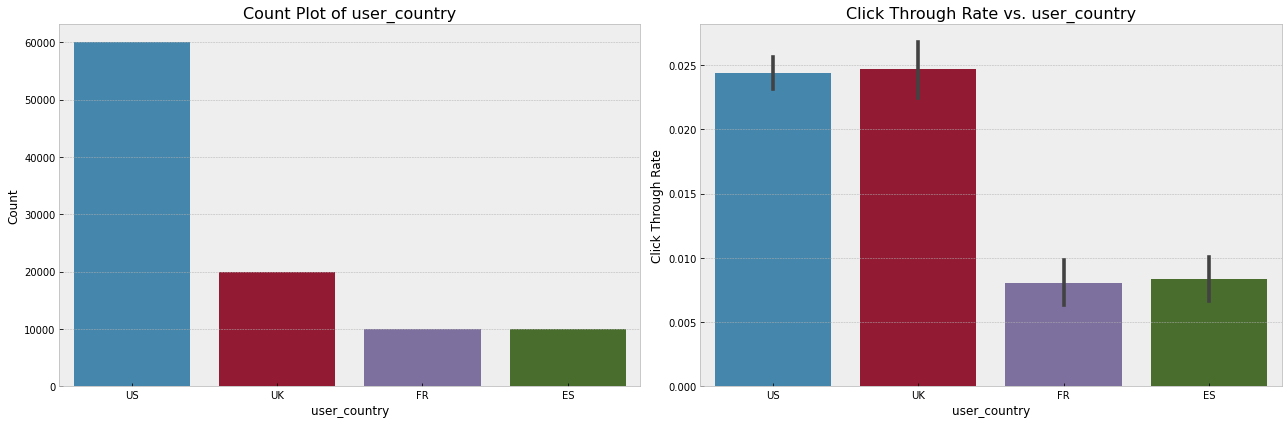

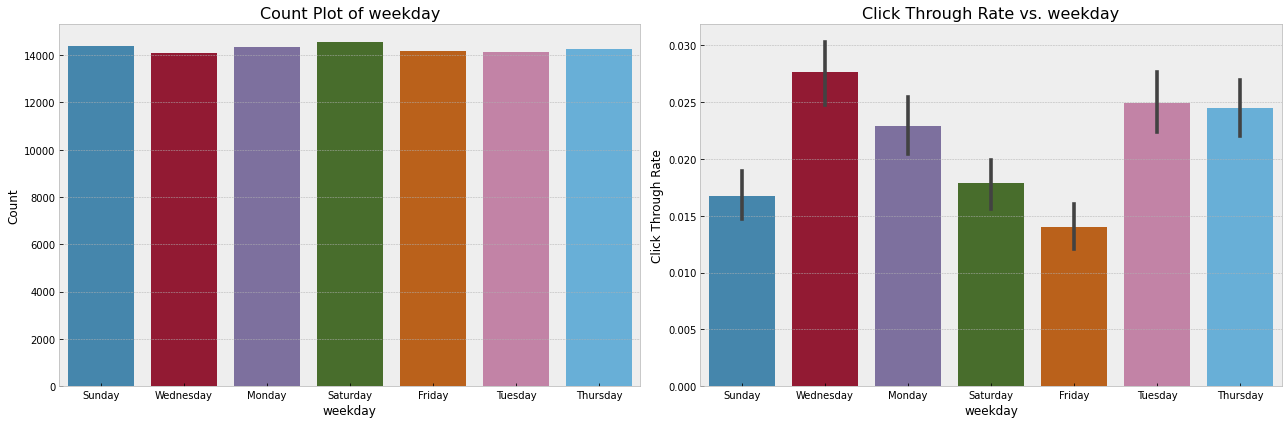

In [10]:
# define cols
cat_cols = ['email_text', 'email_version', 'user_country', 'weekday']
for col in cat_cols:
    plot_cat(col)

- For email Length, short emails are more likely to be opened and clicked 

- For email version, personalized emails are more likely to be opened and clicked 

- For user country, customer from UK and Uk are more likely to open and click the ads 

- Customer are more likely to open ads on Monday, Tuesday, Wednesday and Thursday

## Numerical Variables Exploration

In [11]:
def plot_num(col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    sns.countplot(x=col, data=total_df, ax=ax[0])
    ax[0].set_xlabel(col, fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Count Plot of '+col, fontsize=16)

    sns.barplot(x=col, y='click', data=total_df, ax=ax[1])
    ax[1].set_xlabel(col, fontsize=12)
    ax[1].set_ylabel('Click Through Rate', fontsize=12)
    ax[1].set_title('Click Through Rate vs. '+col, fontsize=16)
    plt.tight_layout()
    plt.show()

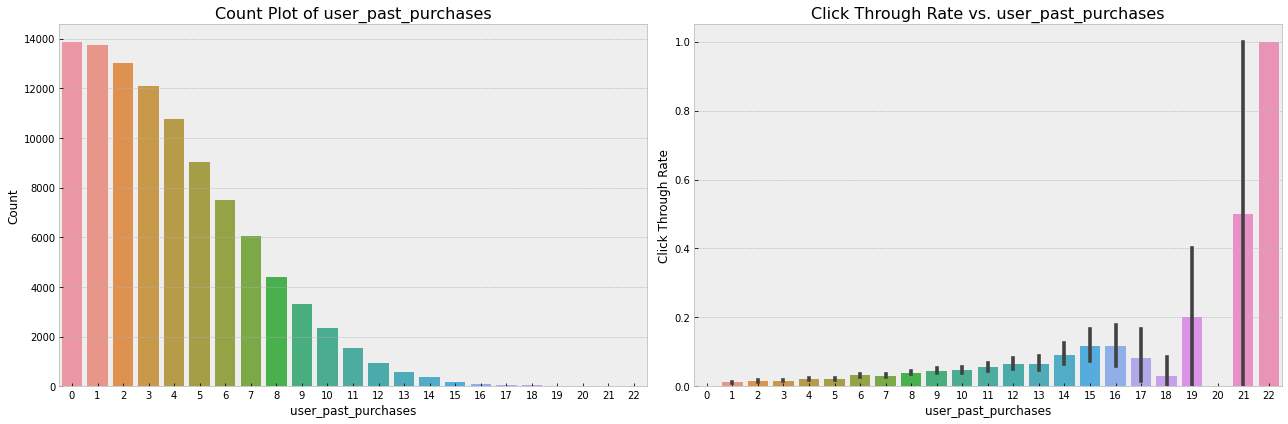

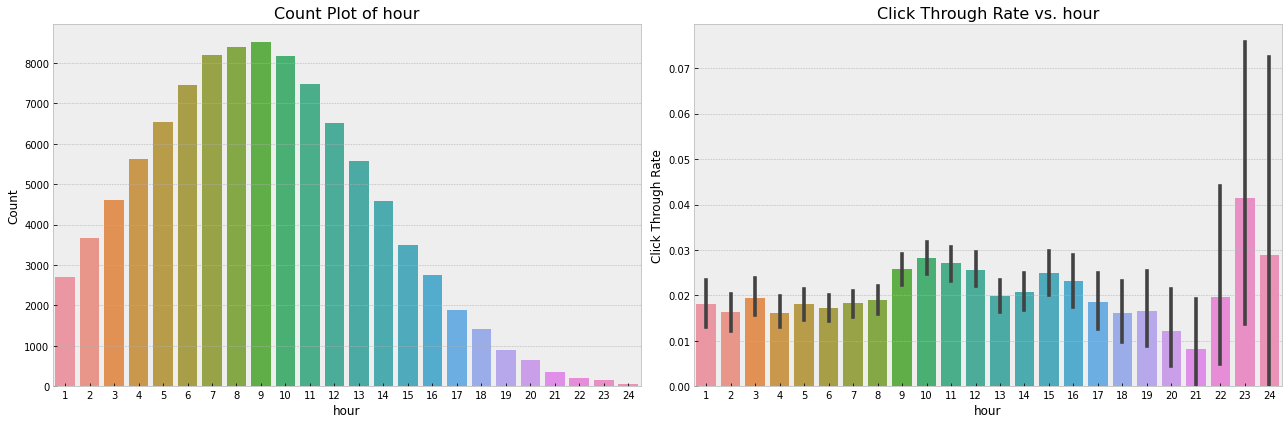

In [12]:
num_cols = ['user_past_purchases','hour']
for col in num_cols:
    plot_num(col)

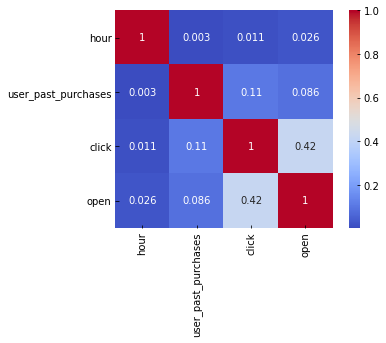

In [13]:
# correlation heat map for the numeric data 
sns.heatmap(total_df[['hour', 'user_past_purchases', 'click', 'open']].corr(),
            annot=True,
            cmap='coolwarm',
            square=True)

# Goal
---

- What percentage of users opened the email and what percentage clicked on the link within the email?

- Can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

- By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

- Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain.

## What percentage of users opened the email and what percentage clicked on the link within the email?

In [14]:
print(round(len(open_table) / len(email),4)*100,'% of email are opened')

10.35 % of email are opened


In [15]:
print(round(len(link_click) / len(email),4)*100,'% of email are opened')

2.12 % of email are opened


## Can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?

In [16]:
total_df['click'].value_counts()

0    97881
1     2119
Name: click, dtype: int64

In [17]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.5" 2019-10-15 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.5+10-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.5+10-LTS, mixed mode)
  Starting server from /Users/matsujun/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp9koib2h4
  JVM stdout: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp9koib2h4/h2o_matsujun_started_from_python.out
  JVM stderr: /var/folders/3w/1j4y1jns6hb89zd6xxfyjzwr0000gn/T/tmp9koib2h4/h2o_matsujun_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_matsujun_083d57
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [19]:
# Transform to H2O Frame, and make sure the target variable is categorical
# classfication 
h2o_df = H2OFrame(total_df)
h2o_df['click'] = h2o_df['click'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,click,open
type,int,enum,enum,int,enum,enum,int,enum,int
mins,8.0,,,1.0,,,0.0,,0.0
mean,498690.1961600027,,,9.059300000000045,,,3.878450000000022,,0.10345
maxs,999998.0,,,24.0,,,22.0,,1.0
sigma,289230.7275342937,,,4.4396374417069655,,,3.1961097835771355,,0.3045472459081676
zeros,0,,,0,,,13877,,89655
missing,0,0,0,0,0,0,0,0,0
0,85120.0,short_email,personalized,2.0,Sunday,US,5.0,0,0.0
1,966622.0,long_email,personalized,12.0,Sunday,UK,2.0,1,1.0
2,777221.0,long_email,personalized,11.0,Wednesday,US,2.0,0,0.0


In [25]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['click'].stratified_split(test_frac=0.2, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']
target = 'click'

In [26]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=10, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
model.accuracy

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1598457290982_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.0,100.0,521170.0,10.0,10.0,10.0,289.0,499.0,409.35




ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.4562092003571866
RMSE: 0.6754326023795317
LogLoss: 1.6267369399762117
Mean Per-Class Error: 0.22636294781033528
AUC: 0.8551478497897996
AUCPR: 0.8275386331261197
Gini: 0.7102956995795993

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.016624101675088144: 


,,0,1,Error,Rate
0,0,47484.0,30821.0,0.3936,(30821.0/78305.0)
1,1,5166.0,73142.0,0.066,(5166.0/78308.0)
2,Total,52650.0,103963.0,0.2298,(35987.0/156613.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.016624,0.802563,324.0
1,max f2,0.011439,0.896877,347.0
2,max f0point5,0.032317,0.763448,258.0
3,max accuracy,0.018586,0.773639,315.0
4,max precision,0.294248,1.000000,0.0
5,max recall,0.004379,1.000000,376.0
6,max specificity,0.294248,1.000000,0.0
7,max absolute_mcc,0.016624,0.572001,324.0
8,max min_per_class_accuracy,0.027017,0.761458,281.0
9,max mean_per_class_accuracy,0.018586,0.773637,315.0



Gains/Lift Table: Avg response rate: 50.00 %, avg score:  3.13 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010006,0.114728,1.955291,1.955291,0.977664,0.135304,0.977664,0.135304,0.019564,0.019564,95.529120,95.529120,0.019117
1,2,0.020005,0.097410,1.899070,1.927189,0.949553,0.104563,0.963613,0.119938,0.018989,0.038553,89.906962,92.718938,0.037097
2,3,0.030004,0.089646,1.846708,1.900368,0.923372,0.093188,0.950202,0.111023,0.018466,0.057018,84.670792,90.036794,0.054030
3,4,0.040003,0.084426,1.847985,1.887274,0.924010,0.086879,0.943655,0.104988,0.018478,0.075497,84.798504,88.727430,0.070989
4,5,0.050002,0.080341,1.824997,1.874820,0.912516,0.082330,0.937428,0.100457,0.018248,0.093745,82.499697,87.482043,0.087488
5,6,0.100004,0.065964,1.745082,1.809951,0.872558,0.072527,0.904993,0.086492,0.087258,0.181003,74.508214,80.995128,0.162001
6,7,0.150000,0.056584,1.679661,1.766525,0.839847,0.060912,0.883279,0.077966,0.083976,0.264979,67.966131,76.652499,0.229962
7,8,0.200003,0.048920,1.621218,1.730197,0.810624,0.052647,0.865115,0.071636,0.081065,0.346044,62.121783,73.019704,0.292088
8,9,0.300001,0.039948,1.542273,1.667557,0.771151,0.044095,0.833794,0.062456,0.154224,0.500268,54.227299,66.755702,0.400543
9,10,0.399999,0.033805,1.390945,1.598405,0.695486,0.036626,0.799218,0.055999,0.139092,0.639360,39.094456,59.840501,0.478732




Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2020-08-26 11:57:28,0.078 sec,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,,2020-08-26 11:57:29,0.783 sec,1.0,0.668222,1.604269,0.800546,0.765280,1.826717,0.287426
2,,2020-08-26 11:57:29,1.121 sec,2.0,0.668414,1.599411,0.807732,0.772134,1.841940,0.280140
3,,2020-08-26 11:57:29,1.524 sec,3.0,0.669368,1.602343,0.811818,0.775676,1.848081,0.277272
4,,2020-08-26 11:57:30,1.733 sec,4.0,0.670424,1.607324,0.815768,0.779724,1.859748,0.274176
5,,2020-08-26 11:57:30,1.919 sec,5.0,0.670836,1.605680,0.819936,0.782873,1.850766,0.266076
6,,2020-08-26 11:57:30,2.123 sec,6.0,0.671732,1.614225,0.822725,0.786566,1.855832,0.263395
7,,2020-08-26 11:57:30,2.316 sec,7.0,0.672090,1.615337,0.826015,0.790245,1.859569,0.259974
8,,2020-08-26 11:57:30,2.511 sec,8.0,0.672680,1.617714,0.828223,0.792944,1.878868,0.261343
9,,2020-08-26 11:57:31,2.693 sec,9.0,0.672717,1.616615,0.830803,0.796605,1.885095,0.258560



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,user_past_purchases,385720.000000,1.000000,0.487791
1,user_country,113977.062500,0.295492,0.144138
2,hour,113623.359375,0.294575,0.143691
3,weekday,97902.851562,0.253818,0.123810
4,email_version,59797.804688,0.155029,0.075622
5,email_text,19726.923828,0.051143,0.024947


<bound method H2OBinomialModel.accuracy of >

In [39]:
model.accuracy()

[[0.01858563538008158, 0.7736394807583024]]

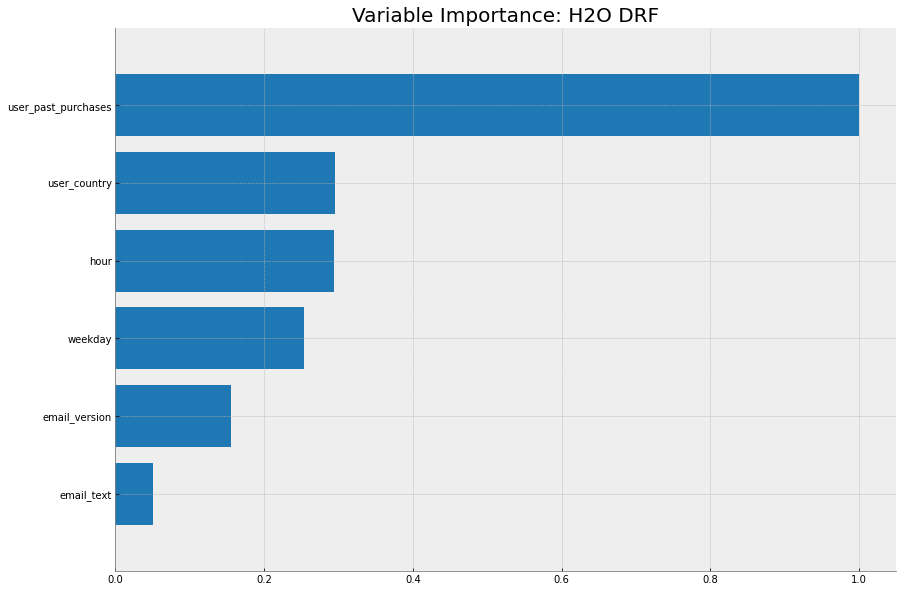

In [29]:
importance = model.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


/Users/matsujun/opt/anaconda3/lib/python3.7/site-packages/h2o/model/model_base.py:1365: MatplotlibDeprecationWarning: The parameter where must have the same size as x in fill_between(). This will become an error in future versions of Matplotlib.
  axs.fill_between(x, lower, upper, where=lower < upper, alpha=0.1, interpolate=False)


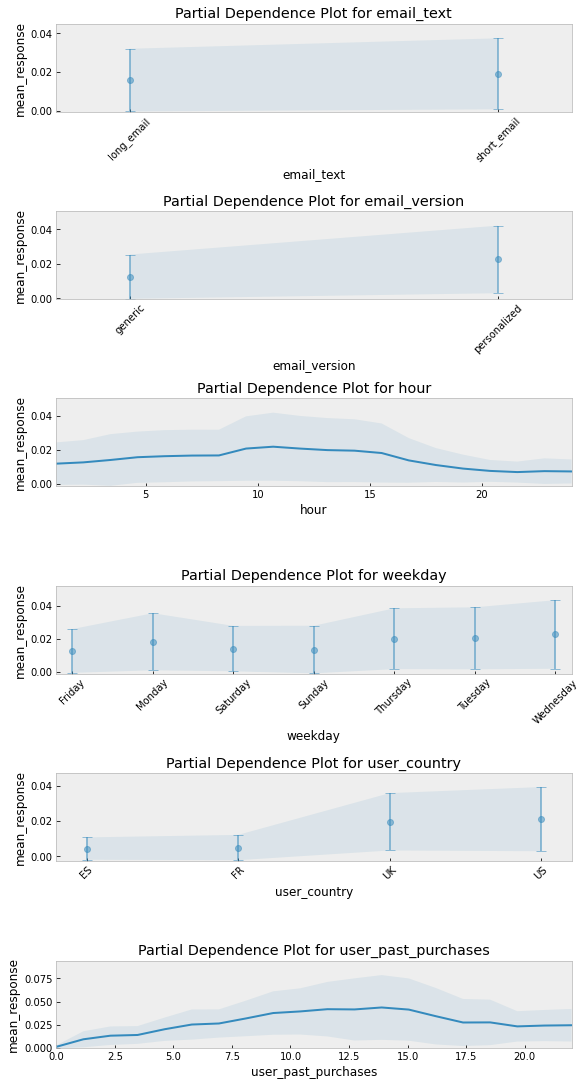

In [35]:
# Partial dependence plot
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

## By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

To test it, we can conduct A/B test to see if the built model can actually help improve the click-through-rate.
* Randomly assign users to two groups, Control group and Experiment group.
* In Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
* In Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
* Preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.